In [13]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes
from source.kinetic_mechanisms import JaxKineticMechanisms as jm
from source.building_models import JaxKineticModelBuild as jkm
import jax.numpy as jnp
import jax
import numpy as np
from source.utils import get_logger
logger = get_logger(__name__)
import diffrax 
import matplotlib.pyplot as plt
import pandas as pd


/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


In [32]:


#Add reactions v1 to v3
v1=jkm.Reaction(
    name="v1",
    species=['m1','m2'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Irrev_Uni(substrate="m1",vmax="A_Vmax",km_substrate="A_Km"),
    )

v2=jkm.Reaction(
    name="v2",
    species=['m2','m3'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Irrev_Uni(substrate="m2",vmax="B_Vmax",km_substrate="B_Km"),
    )

v3=jkm.Reaction(
    name="v3",
    species=['m2','m4'],
    stoichiometry=[-1,1],
    compartments=['c','c'],
    mechanism=jm.Jax_MM_Irrev_Uni(substrate="m2",vmax="C_Vmax",km_substrate="C_Km"),
    )


reactions=[v1,v2,v3]
compartment_values={'c':1}


# initialized the kinetic model object, and then make it a simulation object through jkm.NeuralODE
kmodel=jkm.JaxKineticModel_Build(reactions,compartment_values)
kmodel_sim=jkm.NeuralODE(kmodel)
print(kmodel.stoichiometric_matrix)


     v1   v2   v3
m1 -1.0  0.0  0.0
m2  1.0 -1.0 -1.0
m3  0.0  1.0  0.0
m4  0.0  0.0  1.0


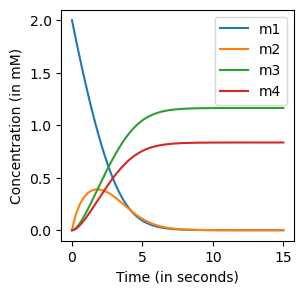

In [47]:
#define the time interval, and the initial conditions
ts=jnp.linspace(0,15,1000)
y0=jnp.array([2,0,0,0])
params=dict(zip(kmodel.parameter_names,jnp.array([1,1,1,1,1.5,1])))

#jit the kmodel object. This results in a slow initial solve, but a c-compiled solve
kmodel_sim=jax.jit(kmodel_sim)
ys=kmodel_sim(ts,y0,params)
ys=pd.DataFrame(ys,columns=kmodel.species_names)

fig,ax=plt.subplots(figsize=(3,3))
ax.plot(ts,ys['m1'],label="m1")
ax.plot(ts,ys['m2'],label="m2")
ax.plot(ts,ys['m3'],label="m3")
ax.plot(ts,ys['m4'],label="m4")
ax.set_xlabel("Time (in seconds)")
ax.set_ylabel("Concentration (in mM)")
ax.legend()
fig.savefig("docs/docs/images/timeseries_example.png",bbox_inches="tight")

     v1   v2   v3
m2  1.0 -1.0 -1.0
m3  0.0  1.0  0.0
m4  0.0  0.0  1.0


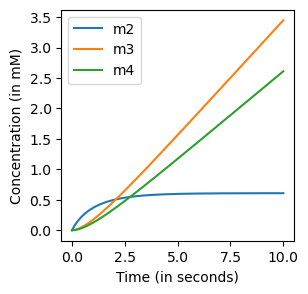

In [16]:
kmodel.add_boundary('m1',jkm.BoundaryCondition(2))
print(kmodel.stoichiometric_matrix)

kmodel_sim=jkm.NeuralODE(kmodel)
ts=jnp.linspace(0,10,1000)

#we remove m1 from y0, as this is now not evaluated by solving
y0=jnp.array([0,0,0])
params=dict(zip(kmodel.parameter_names,jnp.array([1,1,1,1,1.5,1])))

#jit the kmodel object. This results in a slow initial solve, but a c-compiled solve
kmodel_sim=jax.jit(kmodel_sim)
ys=kmodel_sim(ts,y0,params)
ys=pd.DataFrame(ys,columns=kmodel.species_names)

fig,ax=plt.subplots(figsize=(3,3))
ax.plot(ts,ys['m2'],label="m2")
ax.plot(ts,ys['m3'],label="m3")
ax.plot(ts,ys['m4'],label="m4")
ax.set_xlabel("Time (in seconds)")
ax.set_ylabel("Concentration (in mM)")
ax.legend()
fig.savefig("docs/docs/images/timeseries_example_boundary.png",bbox_inches="tight")

In [92]:





def perturbed_simulation(kmodel_sim,ts,y0,params):

    ys=kmodel_sim(ts,y0=y0,params=params)
    return ys[2,-1]


vmapped_perturb=jax.vmap(perturbed_simulation,in_axes=(None,None,None,0))
# vmapped_perturb(kmodel_sim,ts,y0,params)




     v1   v2   v3
m2  1.0 -1.0 -1.0
m3  0.0  1.0  0.0
m4  0.0  0.0  1.0


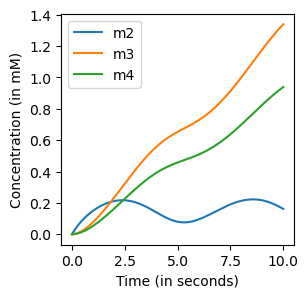

In [20]:
reactions=[v1,v2,v3]
compartment_values={'c':1}
# initialized the kinetic model object, and then make it a simulation object through jkm.NeuralODE
kmodel=jkm.JaxKineticModel_Build(reactions,compartment_values)
kmodel.add_boundary('m1',jkm.BoundaryCondition('0.3+(0.2*sin(t))'))
print(kmodel.stoichiometric_matrix)

kmodel_sim=jkm.NeuralODE(kmodel)
ts=jnp.linspace(0,10,1000)

#we remove m1 from y0, as this is now not evaluated by solving
y0=jnp.array([0,0,0])
params=dict(zip(kmodel.parameter_names,jnp.array([1,1,1,1,1.5,1])))

#jit the kmodel object. This results in a slow initial solve, but a c-compiled solve
kmodel_sim=jax.jit(kmodel_sim)
ys=kmodel_sim(ts,y0,params)
ys=pd.DataFrame(ys,columns=kmodel.species_names)

fig,ax=plt.subplots(figsize=(3,3))
ax.plot(ts,ys['m2'],label="m2")
ax.plot(ts,ys['m3'],label="m3")
ax.plot(ts,ys['m4'],label="m4")
ax.set_xlabel("Time (in seconds)")
ax.set_ylabel("Concentration (in mM)")
ax.legend()
fig.savefig("docs/docs/images/timeseries_example_boundary_sin.png",bbox_inches="tight")

     v1   v2   v3
m2  1.0 -1.0 -1.0
m3  0.0  1.0  0.0
m4  0.0  0.0  1.0


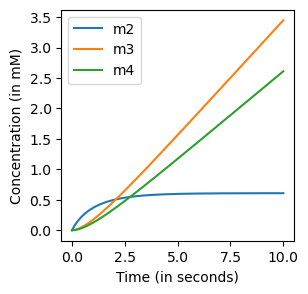

In [26]:
reactions=[v1,v2,v3]
compartment_values={'c':1}
# initialized the kinetic model object, and then make it a simulation object through jkm.NeuralODE
kmodel=jkm.JaxKineticModel_Build(reactions,compartment_values)
kmodel.add_boundary('m1',diffrax.LinearInterpolation(ts=jnp.array([0,1,2]),ys=jnp.array([2,2,2])))
print(kmodel.stoichiometric_matrix)

kmodel_sim=jkm.NeuralODE(kmodel)
ts=jnp.linspace(0,10,1000)

#we remove m1 from y0, as this is now not evaluated by solving
y0=jnp.array([0,0,0])
params=dict(zip(kmodel.parameter_names,jnp.array([1,1,1,1,1.5,1])))

#jit the kmodel object. This results in a slow initial solve, but a c-compiled solve
kmodel_sim=jax.jit(kmodel_sim)
ys=kmodel_sim(ts,y0,params)
ys=pd.DataFrame(ys,columns=kmodel.species_names)

fig,ax=plt.subplots(figsize=(3,3))
ax.plot(ts,ys['m2'],label="m2")
ax.plot(ts,ys['m3'],label="m3")
ax.plot(ts,ys['m4'],label="m4")
ax.set_xlabel("Time (in seconds)")
ax.set_ylabel("Concentration (in mM)")
ax.legend()